###### pierwszy kod

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib

# Function to apply Gaussian filter
def apply_gaussian_filter(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Function to load, resize and preprocess images
def load_and_preprocess_image(image_path, scale_percent, filter_type=False):
    image = cv2.imread(image_path)
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (new_width, new_height))
    
    if filter_type:
        resized_image = apply_gaussian_filter(resized_image)
        print("Filtered with Gaussian")
    
    return resized_image

In [2]:
# Load the original image
original_image_path = "../satellite-images/Miami.jpg"
filter_true = False  # No Gaussian filter
scale_percent = 100  # Use 5% scaling for quicker processing
original_image_rescaled = load_and_preprocess_image(original_image_path, scale_percent, filter_true)



# Load the water mask from the .pkl file
# water_mask_pkl_path = '../svm-gauss-results/svm-model-gauss-2p/Miami_3p_water_mask.pkl'
water_mask_pkl_path = '../dilated_image_water_mask.pkl'
water_mask_binary = joblib.load(water_mask_pkl_path)
water_mask_image_rescaled = cv2.resize(water_mask_binary, (original_image_rescaled.shape[1], original_image_rescaled.shape[0]), interpolation=cv2.INTER_NEAREST)

unique_values_initial = np.unique(water_mask_binary)
print(f"Unique values in the initial water mask: {unique_values_initial}")
unique_values_resized = np.unique(water_mask_image_rescaled)
print(f"Unique values in the resized water mask: {unique_values_resized}")

Unique values in the initial water mask: [0 1]
Unique values in the resized water mask: [0 1]


In [3]:
water_mask_image_rescaled_binary = water_mask_image_rescaled

# Overlay the water mask on the original image
overlay_image = original_image_rescaled.copy()
overlay_image[water_mask_image_rescaled_binary == 0] = [0, 255, 0]  # Highlight water areas in green

In [4]:
# # Display the original image, water mask, and overlay
# plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)
# plt.title('Original Image (Rescaled)')
# plt.imshow(cv2.cvtColor(original_image_rescaled, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
# plt.title('Water Mask (Rescaled)')
# plt.imshow(water_mask_image_rescaled, cmap='gray')

# plt.figure(figsize=(20, 30))
# plt.title('Overlay of Original Image and Water Mask')
# plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

# plt.show()

In [5]:
# Function to divide image into squares and store in dictionary
def divide_image_into_squares(image, square_size):
    squares_dict = {}
    img_height, img_width = image.shape[:2]
    square_id = 0
    
    for y in range(0, img_height, square_size):
        for x in range(0, img_width, square_size):
            square = image[y:y+square_size, x:x+square_size]
            squares_dict[square_id] = square
            square_id += 1
    
    return squares_dict

# Function to draw grid lines on the image
def draw_grid_lines(image, square_size, line_thickness=2):
    img_height, img_width = image.shape[:2]
    grid_image = image.copy()
    
    # Draw horizontal lines
    for y in range(0, img_height, square_size):
        cv2.line(grid_image, (0, y), (img_width, y), (0, 0, 255), line_thickness)
    
    # Draw vertical lines
    for x in range(0, img_width, square_size):
        cv2.line(grid_image, (x, 0), (x, img_height), (0, 0, 255), line_thickness)
    
    return grid_image

# Function to reconstruct color image from squares
def reconstruct_color_image_from_squares(squares_dict, img_height, img_width, square_size):
    reconstructed_image = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    
    square_id = 0
    for y in range(0, img_height, square_size):
        for x in range(0, img_width, square_size):
            reconstructed_image[y:y+square_size, x:x+square_size] = squares_dict[square_id]
            square_id += 1
    
    return reconstructed_image

# Function to reconstruct binary mask from squares
def reconstruct_binary_mask_from_squares(squares_dict, img_height, img_width, square_size):
    reconstructed_image = np.zeros((img_height, img_width), dtype=np.uint8)
    
    square_id = 0
    for y in range(0, img_height, square_size):
        for x in range(0, img_width, square_size):
            reconstructed_image[y:y+square_size, x:x+square_size] = squares_dict[square_id]
            square_id += 1
    
    return reconstructed_image


In [9]:
# Define square size
square_size = 1000  # Example size, you can adjust it as needed

# Divide the original image and water mask into squares
original_image_squares = divide_image_into_squares(original_image_rescaled, square_size)
water_mask_squares = divide_image_into_squares(water_mask_image_rescaled, square_size)


# Draw grid lines on the original image and water mask
line_thickness = 25
original_image_with_grid = draw_grid_lines(original_image_rescaled, square_size, line_thickness)
water_mask_with_grid = draw_grid_lines(water_mask_image_rescaled, square_size, line_thickness)

In [23]:
# # Display the original image and water mask with grid lines
# display_squared_image = plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.title('Original Image with Grid')
# plt.imshow(cv2.cvtColor(original_image_with_grid, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
# plt.title('Water Mask with Grid')
# plt.imshow(water_mask_with_grid, cmap='gray')

##### Detekcja łódek - metoda histogramem

In [15]:
# Function to compute color histograms
def compute_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist

# Function to compare histograms and classify
def is_boat_segment(segment, reference_hist, threshold=0.9):
    segment_hist = compute_histogram(segment)
    similarity = cv2.compareHist(reference_hist, segment_hist, cv2.HISTCMP_CORREL)
    return similarity > threshold, segment_hist, similarity


In [16]:
sample_boat_image = joblib.load("../all-boats-histogram-method/reference_boat_image_50p_100sq.pkl")
sample_boat_hist = compute_histogram(sample_boat_image)

In [17]:
# # Analyze one segment for testing purposes
# test_square_id = 10513  # Change this to test different squares

# plt.figure(figsize=(3,3))
# plt.title('Chosen square')
# plt.imshow(cv2.cvtColor(original_image_squares[test_square_id], cv2.COLOR_BGR2RGB))


# if np.any(water_mask_squares[test_square_id] == 1):  # Check if the segment contains water
#     is_boat, segment_hist, similarity = is_boat_segment(original_image_squares[test_square_id], sample_boat_hist)
#     print(f"Similarity for square {test_square_id}: {similarity}")
#     # Visualize histograms
#     plt.figure(figsize=(5, 3))
    
#     # Plot reference boat histogram
#     plt.subplot(1, 2, 1)
#     plt.title('Reference Boat Histogram')
#     plt.plot(sample_boat_hist.flatten())
    
#     # Plot test segment histogram
#     plt.subplot(1, 2, 2)
#     plt.title('Test Segment Histogram')
#     plt.plot(segment_hist.flatten())
    
#     plt.show()
    
#     # Visualize test segment
#     plt.figure(figsize=(3, 3))
#     plt.title(f'Test Segment {test_square_id} ({"Boat" if is_boat else "Not Boat"})')
#     plt.imshow(cv2.cvtColor(original_image_squares[test_square_id], cv2.COLOR_BGR2RGB))
#     plt.show()

In [22]:
# # Overlay the segments containing water on the original image
# overlay_image = original_image_rescaled.copy()

# for i in range(len(water_mask_squares)):
#     if np.any(water_mask_squares[i] == 0):  # Check if the segment contains water
#         y = (i // (original_image_rescaled.shape[1] // square_size)) * square_size
#         x = (i % (original_image_rescaled.shape[1] // square_size)) * square_size
#         cv2.rectangle(overlay_image, (x, y), (x + square_size, y + square_size), (0, 255, 0), 30)

# # Display the original image with water segments highlighted
# plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(original_image_rescaled, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
# plt.title('Water Segments Highlighted')
# plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

# plt.show()

In [243]:
# # Analyze all segments to detect boats
# boat_segments = []
# for i in range(len(original_image_squares)):
#     if np.any(water_mask_squares[i] == 1):  # Check if the segment contains water
#         is_boat, segment_hist, similarity = is_boat_segment(original_image_squares[i], sample_boat_hist)
#         if is_boat:
#             boat_segments.append(i)

In [242]:
# # Visualize detected boat segments on the original image
# overlay_image = original_image_rescaled.copy()
# for i in boat_segments:
#     y = (i // (original_image_rescaled.shape[1] // square_size)) * square_size
#     x = (i % (original_image_rescaled.shape[1] // square_size)) * square_size
#     cv2.rectangle(overlay_image, (x, y), (x + square_size, y + square_size), (0, 0, 255), 2)

# # Display the original image and overlay image with detected boats
# plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(original_image_rescaled, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
# plt.title('Detected Boats')
# plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

# plt.show()

# Histogram method

Original image dimensions: (13749, 13394, 3)
Water mask dimensions: (13749, 13394)


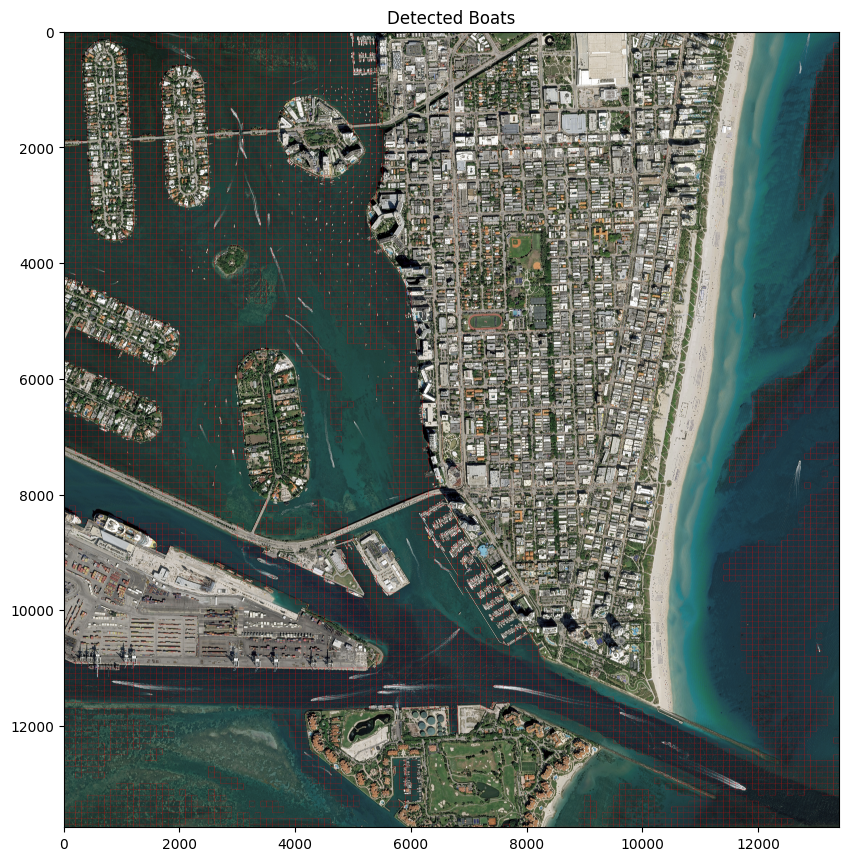

Top 10 similarity values and their coordinates:
Coordinates (3900, 2400): Similarity 1.0
Coordinates (4000, 2400): Similarity 0.9985624883003353
Coordinates (2000, 3400): Similarity 0.9983751829599924
Coordinates (3800, 4200): Similarity 0.9974270611400812
Coordinates (6700, 2900): Similarity 0.9973474560748443
Coordinates (3500, 3700): Similarity 0.997094733653932
Coordinates (8500, 3600): Similarity 0.9969585665838402
Coordinates (3500, 2700): Similarity 0.9965972264109417
Coordinates (6000, 1400): Similarity 0.9965445517402672
Coordinates (1900, 3600): Similarity 0.9963135564961687


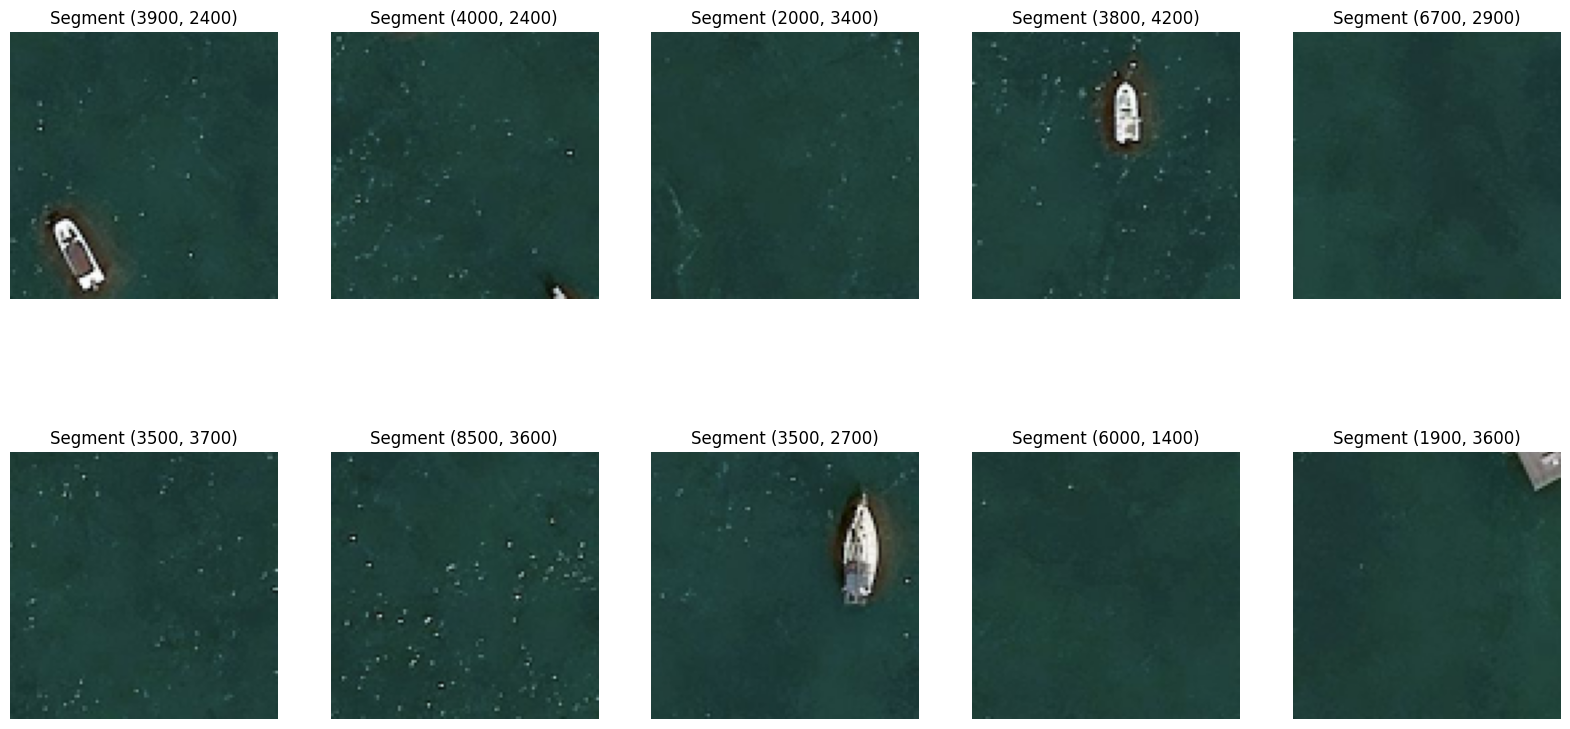

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib

# Function to apply Gaussian filter
def apply_gaussian_filter(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Function to load, resize and preprocess images
def load_and_preprocess_image(image_path, scale_percent, filter_type=False):
    image = cv2.imread(image_path)
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (new_width, new_height))
    
    if filter_type:
        resized_image = apply_gaussian_filter(resized_image)
        print("Filtered with Gaussian")
    
    return resized_image

# Function to draw grid lines on the image
def draw_grid_lines(image, square_size, line_thickness=2, color=(0, 0, 255)):
    img_height, img_width = image.shape[:2]
    grid_image = image.copy()
    
    # Draw horizontal lines
    for y in range(0, img_height, square_size):
        cv2.line(grid_image, (0, y), (img_width, y), color, line_thickness)
    
    # Draw vertical lines
    for x in range(0, img_width, square_size):
        cv2.line(grid_image, (x, 0), (x, img_height), color, line_thickness)
    
    return grid_image

# Function to compute color histograms
def compute_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist

# Function to compare histograms and classify
def is_boat_segment(segment, reference_hist, threshold=0.7):
    segment_hist = compute_histogram(segment)
    similarity = cv2.compareHist(reference_hist, segment_hist, cv2.HISTCMP_CORREL)
    return similarity > threshold, segment_hist, similarity

# Load the original image
original_image_path = "../satellite-images/Miami.jpg"
filter_true = False  # No Gaussian filter
scale_percent = 50  # Use 5% scaling for quicker processing
original_image_rescaled = load_and_preprocess_image(original_image_path, scale_percent, filter_true)

# Load the water mask from the .pkl file
water_mask_pkl_path = '../dilated_image_water_mask.pkl'
water_mask_binary = joblib.load(water_mask_pkl_path)

# Resize the water mask to match the original image dimensions
water_mask_image_rescaled = cv2.resize(water_mask_binary, (original_image_rescaled.shape[1], original_image_rescaled.shape[0]), interpolation=cv2.INTER_NEAREST)

# Verify dimensions
print(f"Original image dimensions: {original_image_rescaled.shape}")
print(f"Water mask dimensions: {water_mask_image_rescaled.shape}")

# Define square size
square_size = 100  # Example size, you can adjust it as needed

# Draw grid lines on the original image and water mask for visual segmentation
original_image_with_grid = draw_grid_lines(original_image_rescaled, square_size)
water_mask_with_grid = draw_grid_lines(water_mask_image_rescaled, square_size)

# # Display the original image and water mask with grid lines
# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.title('Original Image with Grid')
# plt.imshow(cv2.cvtColor(original_image_with_grid, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
# plt.title('Water Mask with Grid')
# plt.imshow(water_mask_with_grid, cmap='gray')

# plt.show()

# Load sample boat image histogram for comparison
sample_boat_image_path = '../all-boats-histogram-method/reference_boat_image_50p_100sq.pkl'
sample_boat_image = joblib.load(sample_boat_image_path)
sample_boat_hist = compute_histogram(sample_boat_image)

# Process and highlight boat segments directly on the original image
overlay_image = original_image_rescaled.copy()
similarity_values = []

for y in range(0, overlay_image.shape[0], square_size):
    for x in range(0, overlay_image.shape[1], square_size):
        segment = original_image_rescaled[y:y+square_size, x:x+square_size]
        if np.any(water_mask_image_rescaled[y:y+square_size, x:x+square_size] == 1):  # Check if the segment contains water
            is_boat, segment_hist, similarity = is_boat_segment(segment, sample_boat_hist)
            similarity_values.append((y, x, similarity))
            if is_boat:
                cv2.rectangle(overlay_image, (x, y), (x + square_size, y + square_size), (0, 0, 255), 2)

# Display the original image and overlay image with detected boats
plt.figure(figsize=(10, 20))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(original_image_rescaled, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
plt.title('Detected Boats')
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

plt.show()

# Sort similarity values in descending order and display top 10 closest similarity values
sorted_similarity_values = sorted(similarity_values, key=lambda x: x[2], reverse=True)
top_10_similarity_values = sorted_similarity_values[:10]
print("Top 10 similarity values and their coordinates:")
for y, x, similarity in top_10_similarity_values:
    print(f"Coordinates ({y}, {x}): Similarity {similarity}")

# Display top 10 detected boat segments
plt.figure(figsize=(20, 10))
for i, (y, x, _) in enumerate(top_10_similarity_values):
    plt.subplot(2, 5, i + 1)
    plt.title(f'Segment ({y}, {x})')
    plt.imshow(cv2.cvtColor(original_image_rescaled[y:y+square_size, x:x+square_size], cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()

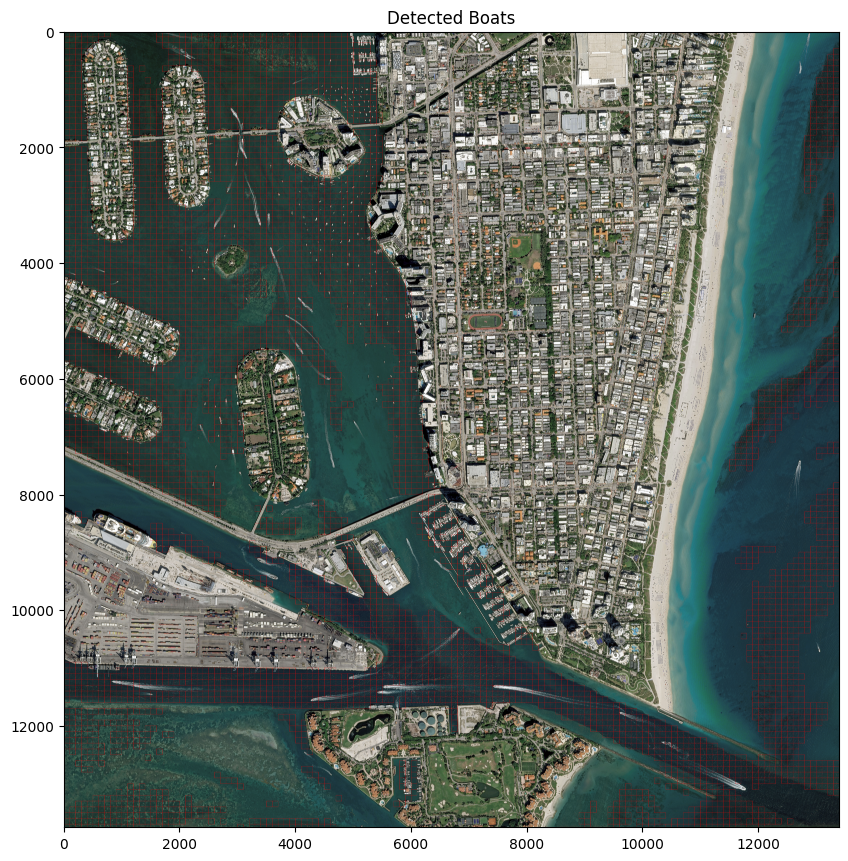

In [15]:
# Process and highlight boat segments directly on the original image
overlay_image = original_image_rescaled.copy()
similarity_values = []

for y in range(0, overlay_image.shape[0], square_size):
    for x in range(0, overlay_image.shape[1], square_size):
        segment = original_image_rescaled[y:y+square_size, x:x+square_size]
        if np.any(water_mask_image_rescaled[y:y+square_size, x:x+square_size] == 1):  # Check if the segment contains water
            is_boat, segment_hist, similarity = is_boat_segment(segment, sample_boat_hist, 0.8)
            similarity_values.append((y, x, similarity))
            if is_boat:
                cv2.rectangle(overlay_image, (x, y), (x + square_size, y + square_size), (0, 0, 255), 2)

# Display the original image and overlay image with detected boats
plt.figure(figsize=(10, 20))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(original_image_rescaled, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
plt.title('Detected Boats')
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

plt.show()

# # Sort similarity values in descending order and display top 10 closest similarity values
# sorted_similarity_values = sorted(similarity_values, key=lambda x: x[2], reverse=True)
# top_10_similarity_values = sorted_similarity_values[:10]
# print("Top 10 similarity values and their coordinates:")
# for y, x, similarity in top_10_similarity_values:
#     print(f"Coordinates ({y}, {x}): Similarity {similarity}")

# # Display top 10 detected boat segments
# plt.figure(figsize=(20, 10))
# for i, (y, x, _) in enumerate(top_10_similarity_values):
#     plt.subplot(2, 5, i + 1)
#     plt.title(f'Segment ({y}, {x})')
#     plt.imshow(cv2.cvtColor(original_image_rescaled[y:y+square_size, x:x+square_size], cv2.COLOR_BGR2RGB))
#     plt.axis('off')

# plt.show()

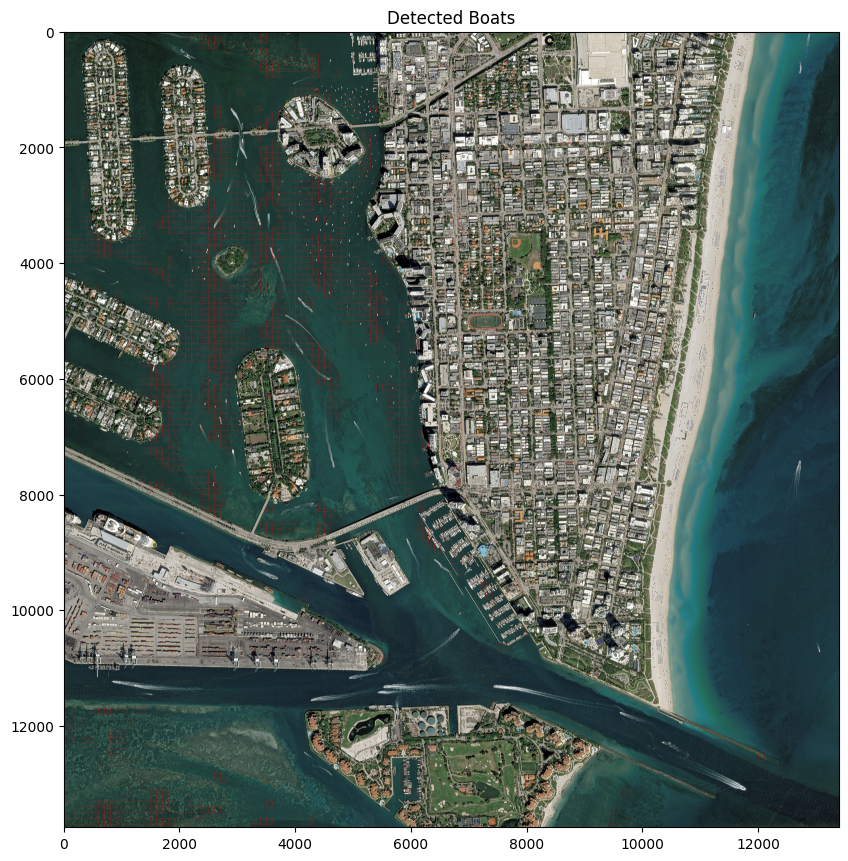

In [13]:
# Process and highlight boat segments directly on the original image
overlay_image = original_image_rescaled.copy()
similarity_values = []

for y in range(0, overlay_image.shape[0], square_size):
    for x in range(0, overlay_image.shape[1], square_size):
        segment = original_image_rescaled[y:y+square_size, x:x+square_size]
        if np.any(water_mask_image_rescaled[y:y+square_size, x:x+square_size] == 1):  # Check if the segment contains water
            is_boat, segment_hist, similarity = is_boat_segment(segment, sample_boat_hist, 0.9)
            similarity_values.append((y, x, similarity))
            if is_boat:
                cv2.rectangle(overlay_image, (x, y), (x + square_size, y + square_size), (0, 0, 255), 2)

# Display the original image and overlay image with detected boats
plt.figure(figsize=(10, 20))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(original_image_rescaled, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
plt.title('Detected Boats')
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

plt.show()

# Sort similarity values in descending order and display top 10 closest similarity values
# sorted_similarity_values = sorted(similarity_values, key=lambda x: x[2], reverse=True)
# top_10_similarity_values = sorted_similarity_values[:10]
# print("Top 10 similarity values and their coordinates:")
# for y, x, similarity in top_10_similarity_values:
#     print(f"Coordinates ({y}, {x}): Similarity {similarity}")

# # Display top 10 detected boat segments
# plt.figure(figsize=(20, 10))
# for i, (y, x, _) in enumerate(top_10_similarity_values):
#     plt.subplot(2, 5, i + 1)
#     plt.title(f'Segment ({y}, {x})')
#     plt.imshow(cv2.cvtColor(original_image_rescaled[y:y+square_size, x:x+square_size], cv2.COLOR_BGR2RGB))
#     plt.axis('off')

# plt.show()

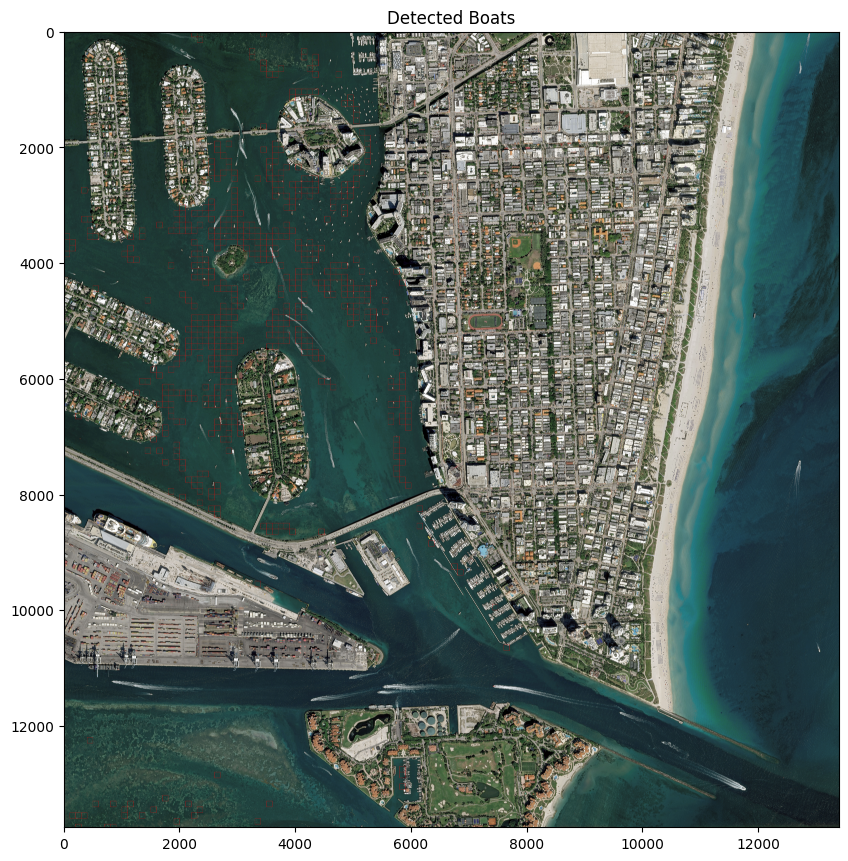

In [14]:
# Process and highlight boat segments directly on the original image
overlay_image = original_image_rescaled.copy()
similarity_values = []

for y in range(0, overlay_image.shape[0], square_size):
    for x in range(0, overlay_image.shape[1], square_size):
        segment = original_image_rescaled[y:y+square_size, x:x+square_size]
        if np.any(water_mask_image_rescaled[y:y+square_size, x:x+square_size] == 1):  # Check if the segment contains water
            is_boat, segment_hist, similarity = is_boat_segment(segment, sample_boat_hist, 0.95)
            similarity_values.append((y, x, similarity))
            if is_boat:
                cv2.rectangle(overlay_image, (x, y), (x + square_size, y + square_size), (0, 0, 255), 2)

# Display the original image and overlay image with detected boats
plt.figure(figsize=(10, 20))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(original_image_rescaled, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 2, 2)
plt.title('Detected Boats')
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

plt.show()

# # Sort similarity values in descending order and display top 10 closest similarity values
# sorted_similarity_values = sorted(similarity_values, key=lambda x: x[2], reverse=True)
# top_10_similarity_values = sorted_similarity_values[:10]
# print("Top 10 similarity values and their coordinates:")
# for y, x, similarity in top_10_similarity_values:
#     print(f"Coordinates ({y}, {x}): Similarity {similarity}")

# # Display top 10 detected boat segments
# plt.figure(figsize=(20, 10))
# for i, (y, x, _) in enumerate(top_10_similarity_values):
#     plt.subplot(2, 5, i + 1)
#     plt.title(f'Segment ({y}, {x})')
#     plt.imshow(cv2.cvtColor(original_image_rescaled[y:y+square_size, x:x+square_size], cv2.COLOR_BGR2RGB))
#     plt.axis('off')

# plt.show()